In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=10000
saveFreq=10
lr=0.0005 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='alexnet_regrs'

kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=512
hidden5=512
fc_dim1=512*25*25
fc_dim2=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13','control13']
targetBatch=None
switchFreq=1
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7
plaqueMaskName='PlaqueMask'
plaqueMaskImg='Maskofplaque.tif'
name='cd13regrs_thresh25min12_overlap70area70_01'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnnRegrs_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnnRegrs_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnnRegrs_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
plaqueCentroids={}
plaqueCentroids['disease13']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9494/trimmed_images/'+plaqueMaskName+'.csv', header=0)
plaqueCentroids['disease8']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9723/trimmed_images/'+plaqueMaskName+'.csv', header=0)
maxArea=max(np.max(plaqueCentroids['disease13']['Area']),np.max(plaqueCentroids['disease8']['Area']))
plaqueCutoffRadius=max(int(np.sqrt(maxArea)/2),int(diamThresh_mul/2))
# plaqueSizeFactor=maxArea/100
plaqueSizeFactor=1

In [5]:
maxArea

91098

In [6]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [7]:
s=training_samples[0]
trainInputnp, valInputnp, _,trainLabelsnp,valLabelsnp,_,_,_,_=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)

#all_thresh25min12_overlap70area70_04_shuffled only
trainInputnp=trainInputnp.astype('float32')
valInputnp=valInputnp.astype('float32')
for sidx in range(1,len(training_samples)):
    s=training_samples[sidx]
    if 'disease' in s:
        inputlist=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    if 'control' in s:
        inputlist=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    trainInputnp=np.concatenate((trainInputnp,inputlist[0].astype('float32')),axis=0)
    valInputnp=np.concatenate((valInputnp,inputlist[1].astype('float32')),axis=0)
    trainLabelsnp=np.concatenate((trainLabelsnp,inputlist[3]),axis=0)
    valLabelsnp=np.concatenate((valLabelsnp,inputlist[4]),axis=0)
inputlist=None

sampleIdx=np.arange(trainInputnp.shape[0])
np.random.shuffle(sampleIdx)


plaque1959
no plaque2434
(22355, 18953)
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


In [8]:
npos=0
nneg=0
npos=np.sum(trainLabelsnp!=0)
nneg=trainLabelsnp.shape[0]-npos
print(npos)
print(nneg)
negweight=(nneg+npos)/nneg
posweight=(nneg+npos)/npos

1663
8236


In [5]:
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='alexnet':
    model = modelsCNN.AlexNet(2)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor([negweight,posweight]).cuda().float())
if model_str=='alexnet_regrs':
    model = modelsCNN.AlexNet(1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
    
# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [10]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainInputnp.shape[0]/batchsize))):
        trainIdx=sampleIdx[i*batchsize:min((i+1)*batchsize,trainInputnp.shape[0])]
        
        trainInput=trainInputnp[trainIdx]
        labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(trainInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)

        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,negweight,posweight)
            loss=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
            loss_all+=loss.item()
        else:
            loss=lossCE(pred,labels)
            loss_all+=loss.item()
        if i==0:
            print(pred.flatten())
            print(labels)
        loss.backward()
        optimizer.step()

#     print(pred.flatten())
#     print(labels)
    loss_all=loss_all/int(np.ceil(trainInputnp.shape[0]/batchsize))
    
    model.eval()
    loss_val_all=0
    for i in range(int(np.ceil(valInputnp.shape[0]/batchsize))):
        valInput=valInputnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        labels=valLabelsnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        if use_cuda:
            valInput=torch.tensor(valInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(valInput)

        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,negweight,posweight)
            loss_val_all+=torch.mean(lossCE(pred.flatten(),labels)*weight_curr).item()
        else:
            loss_val_all+=lossCE(pred,labels).item()
        if i==0:
            print(pred.flatten())
            print(labels)
        
#     print(pred.flatten())
#     print(labels)
    loss_val_all=loss_val_all/int(np.ceil(valInputnp.shape[0]/batchsize))
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


tensor([0.0107, 0.0110, 0.0127, 0.0087, 0.0087, 0.0062, 0.0119, 0.0089, 0.0100,
        0.0136, 0.0053, 0.0139, 0.0093, 0.0129, 0.0164, 0.0139],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([18241.8418, 35940.1953, 28194.2070, 22394.2695, 16518.8770, 27270.8438,
        20493.3398, 22386.8223, 34563.8711, 26537.5527, 13905.6367, 18258.3359,
        20529.2012, 21436.5762, 23051.7363, 23654.1543], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0000 loss_train: 969892678.0672 loss_val: 836894113.7297
tensor([25001.7324, 18681.6836, 17233.9531, 15442.3467, 23377.7344, 23114.6914,
        26407.1328, 17212.3691, 18635.7949, 16730.4062, 19418.5098, 16630.3613,
   

tensor([  306.7401, 67805.6719, 26820.1895, 21117.8027,     0.0000, 20450.9414,
        16852.2227, 14869.9541, 40186.1758, 21442.8223,     0.0000, 10722.0605,
        14231.8350,  9033.6299, 40060.3047, 19906.1543], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0009 loss_train: 592556703.1236 loss_val: 456006493.7297
tensor([23973.6582,  8271.2148,  5345.0029,  1896.3491,  5578.4370,  8793.0127,
        33566.9961,     0.0000, 10624.9707,     0.0000, 12818.8486,  2759.0234,
         6482.4541, 13538.2500,     0.0000, 32004.4453], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62334.3359, 26797.8594, 22507.0078,     0.0000, 18739.3184,
        155

Epoch: 0018 loss_train: 271079044.9311 loss_val: 310664580.1757
tensor([10727.4482,  1587.3599,     0.0000,   111.6748,     0.0000,     0.0000,
        14121.0176,     0.0000,  1335.9312,     0.0000,     0.0000,  5346.1309,
          321.6288,   356.8929,     0.0000,  9509.4824], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([  185.8893, 50987.5898, 28502.4902, 37695.1875,     0.0000,  3262.7893,
         2187.8801, 11185.5908, 39160.1680,  3656.5422,     0.0000,  7304.9966,
         6344.0098,     0.0000, 59603.1953, 18890.5449], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0019 loss_train: 250547327.0249 loss_val: 302291824.2348
tensor([14515.9385,   605.8

tensor([ 1325.3363, 70551.5234, 36188.3047, 46776.1328,     0.0000,  5037.9707,
         2826.3267,  9301.7246, 65628.2500,  5151.6782,     0.0000,  2303.5493,
         6143.6768,  3029.3943, 75091.5391, 21080.3633], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0028 loss_train: 134877641.6262 loss_val: 273669462.3378
tensor([21526.0566,  9274.7021,   875.2213,   370.2330,  4524.0093, 26659.0566,
        16778.4785,     0.0000,     0.0000,  1287.2069,  2748.5999,  6317.0400,
         3348.1257,   287.0579,  1235.3280, 17248.1172], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([ 1076.3926, 70660.9219, 33977.7617, 43764.7656,     0.0000,  7564.6582,
         47

Epoch: 0037 loss_train: 92467585.9008 loss_val: 218335619.8879
tensor([11107.0469,   187.9668,     0.0000,     0.0000,     0.0000,  5971.4189,
         6325.0200,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
         1536.3326,     0.0000,     0.0000,  6751.0298], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64375.5664, 30093.1094, 44893.8711,     0.0000,  3429.0015,
          977.5349, 13451.2285, 53109.9648,     0.0000,     0.0000,  3754.9133,
         3294.3384,     0.0000, 60088.5000, 17775.2695], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0038 loss_train: 97121488.4965 loss_val: 226262855.0187
tensor([29777.8477,     0.000

tensor([    0.0000, 54353.6523, 28261.9727, 35996.5469,     0.0000,  3540.9758,
            0.0000,  4159.0327, 60279.2148,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 55223.9688, 13129.8857], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0047 loss_train: 79406041.7557 loss_val: 259113690.0901
tensor([25448.8594,     0.0000,     0.0000,     0.0000,     0.0000, 24138.2715,
         1189.9189,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 48648.8047, 16562.9355, 26928.7676,     0.0000,  4805.7456,
          44

Epoch: 0056 loss_train: 55990381.4582 loss_val: 187636662.1303
tensor([19449.2305,     0.0000,     0.0000,     0.0000,     0.0000, 20722.2500,
         4112.4673,     0.0000,     0.0000,     0.0000,     0.0000,  5024.0396,
         1676.9769,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 49727.9766, 27149.8691, 40209.8320,     0.0000,  9118.2188,
            0.0000, 15233.4746, 50993.1641,   486.2406,     0.0000,   357.6438,
         1574.2260,  3887.9375, 53704.5703, 17816.1934], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0057 loss_train: 61655500.9455 loss_val: 207952790.8062
tensor([36065.8867,  6078.364

tensor([    0.0000, 67754.4766, 12410.1904, 24104.1094,     0.0000,     0.0000,
            0.0000,     0.0000, 52787.0352,     0.0000,     0.0000,     0.0000,
          360.7898,     0.0000, 52998.0234, 11723.4365], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0066 loss_train: 49261957.6619 loss_val: 239103056.7179
tensor([17574.0547,     0.0000,     0.0000,     0.0000,     0.0000,  3266.2974,
         1175.9408,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,  2484.4026], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57066.1328, 22674.9609, 35658.5781,     0.0000,  3875.0874,
            

Epoch: 0075 loss_train: 45770463.0522 loss_val: 218766520.8393
tensor([21229.2598,  3885.4885,     0.0000,     0.0000,     0.0000,  4919.1997,
         1421.0662,     0.0000,   157.8986,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,  2302.9399], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59182.2812, 22318.7715, 42598.1250,     0.0000,  6148.4214,
         1719.0929, 17043.2461, 51799.3750,   968.0291,     0.0000,   352.8353,
          724.0682,  5241.7378, 59750.6719, 17678.1738], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0076 loss_train: 43077454.4866 loss_val: 188613854.3019
tensor([3.4693e+04, 0.0000e+0

tensor([    0.0000, 60129.1016, 21543.0664, 34577.0000,     0.0000,  3765.4268,
            0.0000,  5659.8862, 46271.7109,    86.6626,     0.0000,   117.4988,
         2088.9951,     0.0000, 45354.3828, 11989.1426], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0085 loss_train: 38054110.7114 loss_val: 201000961.8823
tensor([24322.9062,     0.0000,     0.0000,     0.0000,     0.0000,  7194.6123,
            0.0000,     0.0000,   258.3216,     0.0000,     0.0000,  1699.7100,
            0.0000,     0.0000,     0.0000,  4150.4316], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 49559.0273, 12080.7178, 42274.7695,     0.0000,     0.0000,
            

Epoch: 0094 loss_train: 40695018.3998 loss_val: 172937540.0829
tensor([34394.7734,     0.0000,     0.0000,     0.0000,     0.0000, 10557.3877,
         3298.0430,     0.0000,  1286.2504,   227.6164,     0.0000,  2279.7993,
            0.0000,     0.0000,     0.0000,  4432.3345], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52510.1914, 18404.2383, 45194.0664,     0.0000,  2371.9346,
            0.0000,     0.0000, 43656.3516,   951.1044,     0.0000,   167.4285,
         2389.2612,     0.0000, 61018.3086, 13403.2793], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0095 loss_train: 28524670.3389 loss_val: 185528696.1778
tensor([32030.5293,     0.000

tensor([    0.0000, 58848.0859, 21253.7871, 35194.6484,     0.0000,  9226.6396,
          533.9083,     0.0000, 53554.0469,  1958.9355,     0.0000,  1110.4326,
         2272.3130,     0.0000, 47442.6992, 12607.0469], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0104 loss_train: 31446108.8845 loss_val: 191446984.5536
tensor([30397.7012,     0.0000,     0.0000,     0.0000,     0.0000, 18279.3613,
         3359.8071,     0.0000,     0.0000,     0.0000,     0.0000,  1617.4205,
            0.0000,     0.0000,     0.0000,   108.7374], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53972.7344, 26404.6699, 41297.6680,     0.0000,  3232.5750,
            

Epoch: 0113 loss_train: 28278864.7272 loss_val: 160306548.9677
tensor([21116.2344,     0.0000,     0.0000,     0.0000,     0.0000,  9892.1729,
        22920.5684,     0.0000,  1500.2513,    25.6743,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,   171.5220], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.7761e+04, 2.3518e+04, 2.8684e+04, 0.0000e+00, 6.1167e+03,
        7.8626e+02, 3.9369e+02, 6.2538e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0095e+01, 1.6762e+03, 4.4907e+04, 1.3737e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0114 loss_train: 26204393.8302 loss_val: 169675563.8126
tensor([35577.6914,     0.000

tensor([    0.0000, 54444.4297, 19969.5078, 41142.9141,     0.0000,  8009.4194,
         2579.6851,  1505.9084, 47559.6914,  1774.3958,     0.0000,     0.0000,
         1211.2194,  4417.4111, 59373.6055, 16132.3770], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0123 loss_train: 27289871.0546 loss_val: 168436770.2123
tensor([30811.1387,     0.0000,     0.0000,     0.0000,     0.0000, 12612.5674,
            0.0000,     0.0000,     0.0000,   533.2137,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56002.0703, 25757.1992, 50914.1602,     0.0000,  4477.2603,
            

Epoch: 0132 loss_train: 25445289.8639 loss_val: 181528256.1338
tensor([25059.9668,  4042.0183,     0.0000,     0.0000,     0.0000, 19031.4277,
            0.0000,     0.0000,   500.8382,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 69660.3359, 20125.8867, 41669.3789,     0.0000,  3873.2549,
            0.0000,   216.2504, 52144.5898,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 43432.8203, 11779.8672], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0133 loss_train: 32615669.2114 loss_val: 166950126.4011
tensor([29112.9453,     0.000

tensor([    0.0000, 60380.6016, 19144.8848, 45624.1562,     0.0000,  5667.9556,
            0.0000,  1538.9258, 48237.5508,     0.0000,     0.0000,   316.7329,
            0.0000,     0.0000, 50234.1289, 13711.7217], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0142 loss_train: 24792416.1228 loss_val: 185109915.9651
tensor([25202.4414,     0.0000,     0.0000,     0.0000,     0.0000, 11488.6436,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65478.8516, 16531.9043, 51101.2969,     0.0000,  8514.1338,
            

Epoch: 0151 loss_train: 25018389.9262 loss_val: 184357860.7599
tensor([37195.5859,     0.0000,     0.0000,     0.0000,     0.0000,  4622.3242,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62595.2656, 21569.3438, 42170.8867,     0.0000,  3535.6201,
         2000.1176,     0.0000, 49179.9141,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 54411.3359, 16406.9160], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0152 loss_train: 24293178.4376 loss_val: 162414797.1874
tensor([36062.4336,     0.000

tensor([39220.8477,     0.0000,     0.0000,     0.0000,     0.0000, 11753.5537,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 50951.9180, 21259.4199, 33762.5938,     0.0000, 10386.0645,
            0.0000,     0.0000, 58651.4414,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 45200.1797, 13609.2559], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0161 loss_train: 23669835.7783 loss_val: 175925446.3008
tensor([17742.6504,     0.0000,     0.0000,     0.0000,     0.0000,  8775.8809,
            

tensor([    0.0000, 63809.5117, 24859.2637, 31616.2969,     0.0000, 10058.2764,
         4153.2280,  4166.3052, 54012.4453,  2884.6521,     0.0000,     0.0000,
         2777.6155,  8680.0645, 57205.3086, 15108.6338], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0170 loss_train: 28261470.3199 loss_val: 174122362.5076
tensor([28292.2715,     0.0000,     0.0000,     0.0000,     0.0000, 14196.2578,
         3843.4661,     0.0000,     0.0000,  1870.6506,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57169.2344, 26636.5586, 52621.7422,     0.0000,  4065.3062,
            

Epoch: 0179 loss_train: 21563897.9338 loss_val: 145516575.2334
tensor([32015.7578,     0.0000,     0.0000,     0.0000,     0.0000, 15675.5850,
         2039.7064,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62693.2930, 22130.7891, 47219.4805,     0.0000, 10519.3711,
            0.0000,     0.0000, 60321.4766,   130.2335,     0.0000,     0.0000,
            0.0000,     0.0000, 52349.7773, 16996.3184], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0180 loss_train: 17826840.7964 loss_val: 149609878.9082
tensor([2.7504e+04, 0.0000e+0

tensor([    0.0000, 59102.1289, 21279.4141, 42640.8047,     0.0000,  8045.3418,
            0.0000,     0.0000, 45253.9375,  1878.4744,     0.0000,  5612.0405,
         4625.8438,     0.0000, 47066.3867, 11955.9316], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0189 loss_train: 20369470.1328 loss_val: 136572630.2100
tensor([27797.4395,     0.0000,     0.0000,     0.0000,     0.0000, 11048.4268,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,  1709.5393], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([  447.4598, 63326.4102, 21201.4824, 45581.9805,     0.0000,  6389.2266,
         317

Epoch: 0198 loss_train: 17491123.6212 loss_val: 141783756.5100
tensor([33515.7344,     0.0000,     0.0000,     0.0000,     0.0000, 14767.6982,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56475.1484, 21421.4824, 42023.7266,     0.0000,  9128.2480,
            0.0000,   956.6752, 52116.0430,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 51901.5352, 14952.4590], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0199 loss_train: 16316833.7538 loss_val: 154801195.7912
tensor([25675.0625,     0.000

tensor([    0.0000, 56442.6133, 22806.7305, 33601.0742,     0.0000, 10009.7207,
            0.0000,   137.9908, 54433.0781,  2363.8533,     0.0000,     0.0000,
          813.5577,     0.0000, 45825.5781, 16202.5615], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0208 loss_train: 19658566.3147 loss_val: 181269715.6489
tensor([33033.3359,     0.0000,     0.0000,     0.0000,     0.0000,  9485.0322,
         3365.9138,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 47286.8203, 24475.6230, 46515.6758,     0.0000,  7130.1782,
            

Epoch: 0217 loss_train: 16918294.6379 loss_val: 161007169.6098
tensor([33033.9023,     0.0000,     0.0000,     0.0000,     0.0000,  7403.0244,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,  3864.3328,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64849.7422, 27018.8066, 53070.1602,     0.0000,  4177.9600,
         3220.3723,     0.0000, 48943.8711,     0.0000,     0.0000,     0.0000,
         1112.7479,     0.0000, 48840.2500, 17789.2910], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0218 loss_train: 18033851.7877 loss_val: 145075705.6379
tensor([26966.0312,     0.000

tensor([    0.0000, 55278.7461, 21538.6953, 35441.8828,     0.0000,  3784.8413,
            0.0000,     0.0000, 52284.5859,     0.0000,     0.0000,     0.0000,
           66.3102,     0.0000, 52208.0234, 16901.6113], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0227 loss_train: 18025672.2496 loss_val: 170234079.3695
tensor([34660.6719,     0.0000,     0.0000,     0.0000,     0.0000, 13869.9365,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58326.0195, 20563.1914, 42553.3672,     0.0000,  5247.3687,
         111

Epoch: 0236 loss_train: 22287861.3415 loss_val: 144278744.6216
tensor([34709.0898,     0.0000,     0.0000,     0.0000,     0.0000, 12315.5605,
            0.0000,     0.0000,  3078.1008,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59628.4688, 21660.6934, 49937.5234,     0.0000,  8944.4932,
         4574.1836,     0.0000, 56312.1211,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 51652.5703, 19031.9863], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0237 loss_train: 14940915.7449 loss_val: 136330033.6698
tensor([30941.2969,     0.000

tensor([    0.0000, 59921.2969, 26151.2383, 42914.3984,     0.0000,  5922.4824,
         1637.6033,     0.0000, 58832.4297,  1690.5862,     0.0000,     0.0000,
            0.0000,     0.0000, 54951.3008, 20314.5898], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0246 loss_train: 16960724.2390 loss_val: 149175615.5266
tensor([30766.6133,     0.0000,     0.0000,     0.0000,     0.0000, 15668.6387,
            0.0000,     0.0000,   597.6872,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62504.2305, 20359.3789, 36541.8008,     0.0000,  3320.9375,
            

Epoch: 0255 loss_train: 15472249.3925 loss_val: 151935453.4080
tensor([33273.8828,     0.0000,     0.0000,     0.0000,     0.0000, 13703.9854,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58378.0781, 25129.3906, 40645.6445,     0.0000,  5366.8799,
            0.0000,     0.0000, 57194.1328,  2984.1074,     0.0000,     0.0000,
         1153.4847,     0.0000, 50123.9844, 20811.2754], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0256 loss_train: 15609846.1031 loss_val: 154431176.3547
tensor([30940.9941,     0.000

tensor([    0.0000, 62070.6172, 17916.7793, 45422.5039,     0.0000,  4174.7695,
            0.0000,     0.0000, 56160.2383,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 54451.8789, 15533.9189], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0265 loss_train: 12194156.6309 loss_val: 145946911.3041
tensor([28984.2656,     0.0000,     0.0000,     0.0000,     0.0000, 12883.9453,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 55741.0586, 17522.4043, 45915.6016,     0.0000,  1367.3379,
           9

Epoch: 0274 loss_train: 14500973.4251 loss_val: 166110078.8403
tensor([22511.0234,     0.0000,     0.0000,     0.0000,     0.0000, 12517.9990,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61129.8320, 23190.0176, 53355.1250,     0.0000,     0.0000,
         1818.0681,     0.0000, 58642.6680,   154.2472,     0.0000,     0.0000,
            0.0000,     0.0000, 57181.0547, 16619.2363], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0275 loss_train: 16492496.3399 loss_val: 142753662.8006
tensor([29674.5293,     0.000

tensor([    0.0000, 59079.0742, 16236.8242, 46282.1719,     0.0000,  3432.0386,
         3127.4783,     0.0000, 51841.9102,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 53085.3359, 14119.5205], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0284 loss_train: 12700997.0842 loss_val: 175742125.4690
tensor([33640.8906,     0.0000,     0.0000,     0.0000,     0.0000, 11388.2266,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 55080.0820, 20463.7695, 46922.0898,     0.0000,  4847.6118,
          21

Epoch: 0293 loss_train: 13242171.0458 loss_val: 136122107.0283
tensor([41304.8672,     0.0000,     0.0000,     0.0000,     0.0000, 17757.5703,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59803.1094, 24652.6016, 51246.5078,     0.0000,  9887.9033,
            0.0000,     0.0000, 65812.9219,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 61420.2383, 18088.0020], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0294 loss_train: 11372821.7106 loss_val: 133376713.3354
tensor([32920.2148,     0.000

tensor([    0.0000, 62917.7930, 20568.3008, 50138.1797,     0.0000, 13742.7529,
         3195.7642,     0.0000, 54331.9141,     0.0000,     0.0000,  4899.1943,
            0.0000,     0.0000, 50604.3281, 18207.3066], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0303 loss_train: 14163254.5014 loss_val: 133050403.3286
tensor([29105.5996,     0.0000,     0.0000,     0.0000,     0.0000, 12521.8320,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57695.5352, 21741.6836, 40017.7031,     0.0000,  6259.6069,
          52

Epoch: 0312 loss_train: 13521802.5158 loss_val: 181998415.4916
tensor([29855.9961,     0.0000,     0.0000,     0.0000,     0.0000, 13050.2334,
            0.0000,     0.0000,   261.4347,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 49608.0586, 19974.2578, 22353.1914,     0.0000,  4443.3110,
            0.0000,     0.0000, 61581.1680,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 56967.2383, 14146.5332], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0313 loss_train: 15107057.1733 loss_val: 193744350.5826
tensor([20704.0312,     0.000

tensor([    0.0000, 63610.5078, 24977.7441, 44714.6875,     0.0000,  4805.7329,
          105.6258,     0.0000, 63221.5742,     0.0000,     0.0000,  1621.6462,
            0.0000,     0.0000, 50816.9883, 15420.0586], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0322 loss_train: 12841355.8776 loss_val: 126399976.2660
tensor([34338.8398,     0.0000,     0.0000,     0.0000,     0.0000, 11181.6924,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59166.9102, 20105.1387, 45036.6094,     0.0000,  5179.5698,
            

Epoch: 0331 loss_train: 11384454.9785 loss_val: 148222297.0822
tensor([33269.3828,     0.0000,     0.0000,     0.0000,     0.0000, 11097.7842,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63941.9609, 22112.8262, 48613.3359,     0.0000,  6342.3623,
            0.0000,     0.0000, 62479.7852,     0.0000,     0.0000,     0.0000,
         9430.0996,     0.0000, 60250.0156, 13082.2178], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0332 loss_train: 11887997.8188 loss_val: 151872561.6242
tensor([37860.1211,     0.000

tensor([    0.0000, 64283.1836, 26640.5059, 47619.2734,     0.0000,  5663.3535,
            0.0000,     0.0000, 56666.1875,   702.0197,     0.0000,     0.0000,
         1867.2283,     0.0000, 58966.2812, 13612.7822], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0341 loss_train: 11829476.9420 loss_val: 152232586.0414
tensor([33179.1133,     0.0000,     0.0000,     0.0000,     0.0000, 11929.6680,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 50627.7344, 14207.6074, 45948.1328,     0.0000,  1993.1266,
            

Epoch: 0350 loss_train: 12412910.2653 loss_val: 156417475.8794
tensor([30367.0957,     0.0000,     0.0000,     0.0000,     0.0000,  8531.0430,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58814.9375, 24335.5801, 54740.9258,     0.0000, 13252.2773,
         5984.6885,     0.0000, 59612.6875,     0.0000,     0.0000,   671.7429,
            0.0000,     0.0000, 59249.0469, 21388.1504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0351 loss_train: 12402984.2068 loss_val: 135768098.4451
tensor([30607.3320,     0.000

tensor([    0.0000, 61701.7656, 21355.4297, 49652.4609,     0.0000,  3801.2974,
            0.0000,     0.0000, 58416.2891,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 54696.1719, 20614.5176], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0360 loss_train: 16211436.9772 loss_val: 134623865.0819
tensor([31791.1328,     0.0000,     0.0000,     0.0000,     0.0000,  6386.5796,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57565.0430, 25379.3340, 47800.0742,     0.0000,  7579.2944,
         146

Epoch: 0369 loss_train: 10200144.9908 loss_val: 165578230.1320
tensor([16486.6426,     0.0000,     0.0000,     0.0000,     0.0000,  8062.4282,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52906.1289, 18824.3965, 50894.5898,     0.0000,  2735.0286,
         1654.6075,     0.0000, 55629.5781,     0.0000,     0.0000,  4498.3340,
         5787.6895,     0.0000, 54290.3242, 16013.5078], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0370 loss_train: 12149693.9152 loss_val: 144682387.5817
tensor([32833.5039,     0.000

tensor([    0.0000, 55529.8789, 24281.8574, 48262.3203,     0.0000, 10307.4355,
            0.0000,     0.0000, 53702.4844,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 54803.8281, 17822.4824], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0379 loss_train: 10364023.5388 loss_val: 130523658.8911
tensor([29258.2344,     0.0000,     0.0000,     0.0000,     0.0000, 12124.5771,
            0.0000,     0.0000,  2006.5931,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59101.3242, 26106.8594, 44925.6953,     0.0000, 11523.5625,
            

Epoch: 0388 loss_train: 11088011.0577 loss_val: 163008971.9383
tensor([25622.7207,     0.0000,     0.0000,     0.0000,     0.0000, 12436.1494,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57466.3516, 23403.2207, 50391.1367,     0.0000, 12969.9141,
         4799.5469,     0.0000, 60814.6602,     0.0000,     0.0000, 13345.2432,
            0.0000,     0.0000, 56134.3398, 19873.2207], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0389 loss_train: 10162644.0368 loss_val: 142831001.2253
tensor([30197.9434,     0.000

tensor([    0.0000, 54820.2695, 26309.4980, 45723.1680,     0.0000,  9824.6875,
            0.0000,     0.0000, 60936.3359,     0.0000,     0.0000,  2923.8794,
            0.0000,     0.0000, 53275.3789, 23023.1992], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0398 loss_train: 10783157.3240 loss_val: 127581935.5113
tensor([31155.4414,     0.0000,     0.0000,     0.0000,     0.0000, 14631.7871,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64224.2734, 25402.2168, 51659.8242,     0.0000, 10550.8457,
         169

Epoch: 0407 loss_train: 13485908.3647 loss_val: 155237470.9682
tensor([29124.7520,     0.0000,     0.0000,     0.0000,     0.0000, 12218.7959,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 51065.1836, 20633.9160, 53088.9609,     0.0000,  7179.8950,
            0.0000,     0.0000, 53658.6562,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 55411.0547, 18695.2656], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0408 loss_train: 10412946.7616 loss_val: 141008472.5151
tensor([28164.5137,     0.000

tensor([    0.0000, 59834.2266, 29213.4727, 58636.6094,     0.0000, 13982.1201,
            0.0000,     0.0000, 59220.3711,  2125.5710,     0.0000,  7016.4883,
            0.0000,     0.0000, 61283.3633, 21850.7832], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0417 loss_train: 10549166.3253 loss_val: 140881843.3665
tensor([30805.5000,     0.0000,     0.0000,     0.0000,     0.0000, 13503.8291,
            0.0000,     0.0000,     0.0000,  1284.3739,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64441.8672, 27391.1562, 55907.6680,     0.0000, 18603.0410,
         184

Epoch: 0426 loss_train: 9121080.3645 loss_val: 140091712.0923
tensor([28327.4766,     0.0000,     0.0000,     0.0000,     0.0000, 13942.9277,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53926.5586, 22660.8203, 59710.9453,     0.0000, 11740.6055,
         1807.3959,     0.0000, 63782.1016,     0.0000,     0.0000,     0.0000,
         6951.4927,     0.0000, 60772.7656, 21344.8242], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0427 loss_train: 10363565.8134 loss_val: 155454399.1640
tensor([25408.8652,     0.0000

tensor([    0.0000, 55832.6328, 24130.7168, 47712.8711,     0.0000, 10051.7148,
            0.0000,     0.0000, 64262.9336,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 54966.1992, 22590.0469], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0436 loss_train: 9552438.7204 loss_val: 130921597.1400
tensor([30344.4844,     0.0000,     0.0000,     0.0000,     0.0000, 12826.0986,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56774.2148, 28757.1621, 59313.1445,     0.0000, 12029.9180,
         2402

Epoch: 0445 loss_train: 9718291.3005 loss_val: 161745064.3750
tensor([34310.9766,     0.0000,     0.0000,     0.0000,     0.0000, 14482.0117,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53547.9531, 23723.2031, 53015.1562,     0.0000,  6850.2002,
         1273.6058,     0.0000, 55322.4844,     0.0000,     0.0000,     0.0000,
         2416.3655,     0.0000, 54524.5781, 21816.4980], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0446 loss_train: 10144963.0872 loss_val: 149411464.0867
tensor([28819.9980,     0.0000

tensor([    0.0000, 57368.8242, 19378.7754, 51843.5820,     0.0000,  6347.2295,
         5842.3745,     0.0000, 56865.4453,     0.0000,     0.0000,  3365.2886,
            0.0000,     0.0000, 57405.1250, 21054.5996], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0455 loss_train: 9900627.5078 loss_val: 148991845.0376
tensor([30314.9629,     0.0000,     0.0000,     0.0000,     0.0000, 15904.3672,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61975.5156, 22024.9727, 46960.7812,     0.0000,  8871.3408,
         5776

Epoch: 0464 loss_train: 10998459.6133 loss_val: 144645991.7212
tensor([31292.2266,     0.0000,     0.0000,     0.0000,     0.0000, 11438.7012,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61950.2773,  2798.1174, 57272.0781,  1114.8130,  4356.3350,
         3691.7361,     0.0000, 47442.4453,     0.0000,     0.0000,  3769.1997,
            0.0000,     0.0000, 61776.3867, 19569.7578], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0465 loss_train: 11158107.0050 loss_val: 169599715.2988
tensor([28796.3379,     0.000

tensor([    0.0000, 62797.9258, 22278.9316, 53821.2891,     0.0000, 11242.7646,
         5669.0142,     0.0000, 55985.9336,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 57776.8828, 19080.6270], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0474 loss_train: 11118094.0706 loss_val: 138895754.4459
tensor([29742.8652,     0.0000,     0.0000,     0.0000,     0.0000, 10247.9639,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57630.0156, 25010.9453, 49809.5234,     0.0000, 12236.2344,
         427

Epoch: 0483 loss_train: 12804912.9318 loss_val: 143742585.4580
tensor([25557.4570,     0.0000,     0.0000,     0.0000,     0.0000, 13545.2744,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52755.8867, 25784.8926, 50232.4062,     0.0000, 10239.3125,
         5164.2764,     0.0000, 56442.2930,     0.0000,     0.0000,  2863.0469,
         7847.4702,     0.0000, 56429.6758, 21247.5742], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0484 loss_train: 9879463.6237 loss_val: 145452598.9050
tensor([24537.2773,     0.0000

tensor([    0.0000, 59511.2383, 19967.1348, 49016.1914,     0.0000,  8088.0962,
         2620.6008,     0.0000, 55278.2070,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 56815.5586, 19782.4863], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0493 loss_train: 13169856.8269 loss_val: 152126199.9288
tensor([26887.4668,     0.0000,     0.0000,     0.0000,     0.0000, 15841.1602,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 37310.2383, 23005.7734, 51649.6445,     0.0000, 17010.7168,
          55

Epoch: 0502 loss_train: 9864121.9879 loss_val: 123717949.6795
tensor([29931.9102,     0.0000,     0.0000,     0.0000,     0.0000, 14379.3477,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 66600.0000, 25021.7773, 51710.8555,     0.0000, 12521.2949,
         4371.1675,     0.0000, 60491.6992,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 57897.9062, 24376.6914], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0503 loss_train: 8585103.3271 loss_val: 142904201.8758
tensor([27707.2012,     0.0000,

tensor([    0.0000, 63228.9688, 23486.9375, 48697.7852,     0.0000, 10616.8418,
            0.0000,     0.0000, 56575.6094,     0.0000,     0.0000,  5582.0381,
            0.0000,     0.0000, 51001.6484, 20361.9043], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0512 loss_train: 10278832.4256 loss_val: 141534699.5278
tensor([23832.7812,     0.0000,     0.0000,     0.0000,     0.0000, 10370.2822,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60208.5000, 16506.5977, 48089.8320,     0.0000,  7870.5981,
            

Epoch: 0521 loss_train: 9014341.8979 loss_val: 152388116.5321
tensor([26987.0723,     0.0000,     0.0000,     0.0000,     0.0000, 14815.1973,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58329.5625, 22132.9551, 49648.0781,     0.0000, 10539.0693,
         1140.5400,     0.0000, 60223.8242,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 58659.5781, 21141.0527], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0522 loss_train: 8911293.0628 loss_val: 141264770.3905
tensor([32762.9473,     0.0000,

tensor([    0.0000, 58827.6094, 23524.8008, 43726.8164,     0.0000,  2410.0300,
            0.0000,     0.0000, 57938.1133,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 51592.2031, 16202.0811], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0531 loss_train: 9817851.1484 loss_val: 144158684.7353
tensor([28817.0664,     0.0000,     0.0000,     0.0000,     0.0000, 12979.2471,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 50597.4883, 25506.9609, 52048.2461,     0.0000,  4013.9924,
         2817

Epoch: 0540 loss_train: 8339804.4657 loss_val: 133131533.3751
tensor([24868.4102,     0.0000,     0.0000,     0.0000,     0.0000, 16691.1250,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60551.4180, 22303.1016, 52610.6016,     0.0000,  7724.0635,
            0.0000,     0.0000, 60981.7773,     0.0000,     0.0000,  3664.4260,
            0.0000,     0.0000, 56395.2188, 21510.4492], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0541 loss_train: 6929801.2317 loss_val: 132606955.7034
tensor([27042.7793,     0.0000,

tensor([    0.0000, 62871.6445, 21352.4746, 53645.5312,   630.9044,  7309.5728,
            0.0000,     0.0000, 62277.0234,     0.0000,     0.0000,  4594.9521,
         2734.4241,     0.0000, 59675.1016, 14844.4590], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0550 loss_train: 11926388.0156 loss_val: 120531421.6149
tensor([29861.7734,     0.0000,     0.0000,     0.0000,     0.0000, 10987.0645,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 48696.7148, 20511.9395, 52891.4727,     0.0000,  8989.7490,
            

Epoch: 0559 loss_train: 8865220.4980 loss_val: 148875886.1147
tensor([31320.7363,     0.0000,     0.0000,     0.0000,     0.0000, 12023.2441,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59184.5977, 21525.3027, 52970.2617,     0.0000,  5790.3086,
            0.0000,     0.0000, 53993.7891,     0.0000,     0.0000,   594.5575,
            0.0000,     0.0000, 56045.2852, 18940.2070], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0560 loss_train: 10917979.9226 loss_val: 152919324.8924
tensor([28146.5742,     0.0000

tensor([    0.0000, 53797.0195, 21324.5625, 53342.3477,     0.0000,  4706.6421,
            0.0000,     0.0000, 54980.6094,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 58043.9375, 18565.6133], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0569 loss_train: 8468251.3903 loss_val: 144415581.4541
tensor([26099.3477,     0.0000,     0.0000,     0.0000,     0.0000, 14929.4482,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 51664.8359, 30021.8242, 54905.5703,     0.0000, 12248.5156,
         3507

Epoch: 0578 loss_train: 8086980.6942 loss_val: 130944022.5583
tensor([30859.0527,     0.0000,     0.0000,     0.0000,     0.0000, 12108.1445,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58820.0664, 19668.1641, 53068.7305,     0.0000,  7250.3071,
            0.0000,     0.0000, 55066.4609,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 57214.0078, 22880.7422], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0579 loss_train: 8039966.8603 loss_val: 141972379.0163
tensor([30051.7363,     0.0000,

tensor([    0.0000, 67158.3516, 16991.5254, 53485.0547,     0.0000,  3678.2644,
            0.0000,     0.0000, 59323.2266,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 52821.1094, 21171.9805], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0588 loss_train: 8118845.2461 loss_val: 155704014.7640
tensor([29063.5527,     0.0000,     0.0000,     0.0000,     0.0000, 13194.2373,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65869.6719, 16317.0742, 52781.5859,     0.0000, 10133.1660,
          653

Epoch: 0597 loss_train: 8771761.6788 loss_val: 150025815.0277
tensor([31129.6934,     0.0000,     0.0000,     0.0000,     0.0000, 13733.8379,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56254.7109, 19043.3496, 49931.3789,     0.0000,  8428.3096,
            0.0000,     0.0000, 58450.4492,     0.0000,     0.0000,  2940.8438,
            0.0000,     0.0000, 58713.5508, 23424.7090], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0598 loss_train: 7881478.0947 loss_val: 147172321.7501
tensor([28172.5820,     0.0000,

tensor([    0.0000, 54645.5742, 27262.4824, 48911.1836,     0.0000, 11448.3428,
         4105.9990,     0.0000, 60488.8828,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 58389.3633, 22529.4316], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0607 loss_train: 10972646.9941 loss_val: 184370165.4307
tensor([31156.2480,     0.0000,     0.0000,     0.0000,     0.0000, 13635.9219,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61880.2734, 25534.2754, 54589.2969,     0.0000,  6793.8735,
         416

Epoch: 0616 loss_train: 9845807.5073 loss_val: 149437724.9433
tensor([27515.6035,     0.0000,     0.0000,     0.0000,     0.0000, 14449.4590,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65848.9766, 23168.2285, 51412.0352,     0.0000,  7148.8735,
            0.0000,     0.0000, 56227.1680,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 56382.9141, 20660.8027], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0617 loss_train: 8450957.9356 loss_val: 164575627.2863
tensor([28174.0156,     0.0000,

tensor([    0.0000, 57445.6172, 25669.5859, 49376.2422,     0.0000,  6112.5908,
            0.0000,     0.0000, 53695.7578,     0.0000,     0.0000,     0.0000,
         3871.9653,     0.0000, 59338.4766, 19317.6309], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0626 loss_train: 7870962.7217 loss_val: 152362230.5984
tensor([26861.8477,     0.0000,     0.0000,     0.0000,     0.0000, 12199.6592,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56862.5430, 26155.7148, 50464.7930,     0.0000,  8016.2710,
         4700

Epoch: 0635 loss_train: 7345085.6528 loss_val: 138123139.7641
tensor([30491.3340,     0.0000,     0.0000,     0.0000,   163.3940, 14240.3535,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56071.5195, 25394.1367, 51563.1562,     0.0000,  3977.7551,
            0.0000,     0.0000, 57286.3320,     0.0000,     0.0000,  1912.5425,
         3238.7126,     0.0000, 61193.8047, 20454.4844], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0636 loss_train: 7261506.1269 loss_val: 154979527.7988
tensor([28750.1211,     0.0000,

tensor([    0.0000, 57255.4961, 23678.2168, 55873.8047,     0.0000,  8255.5439,
            0.0000,     0.0000, 56069.0352,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 63806.6641, 19821.1777], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0645 loss_train: 8423934.1991 loss_val: 144817912.2080
tensor([28759.6660,     0.0000,     0.0000,     0.0000,     0.0000, 15094.9365,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58326.5469, 27544.3672, 49605.4492,     0.0000,  7422.8096,
         2627

Epoch: 0654 loss_train: 8098636.6685 loss_val: 121387029.8887
tensor([30652.3809,     0.0000,     0.0000,     0.0000,     0.0000, 14032.3398,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64025.1172, 27722.4316, 56237.1094,   704.7592, 10259.9707,
            0.0000,     0.0000, 61029.3594,     0.0000,     0.0000,  7557.2896,
         8533.1035,     0.0000, 58966.2773, 16411.2363], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0655 loss_train: 8759090.5457 loss_val: 134329118.5670
tensor([33004.5469,     0.0000,

tensor([    0.0000, 58736.3711, 27751.5645, 54511.8438,     0.0000,  7688.0396,
         6634.0635,     0.0000, 56546.0273,     0.0000,     0.0000,     0.0000,
         4471.1348,     0.0000, 61582.8203, 19810.1230], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0664 loss_train: 7269188.1352 loss_val: 140388473.9983
tensor([29888.6016,     0.0000,     0.0000,     0.0000,     0.0000, 13510.0928,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63518.5234, 17848.7324, 49354.8281,     0.0000,  6056.1299,
         4439

Epoch: 0673 loss_train: 7260161.9078 loss_val: 138735290.6218
tensor([31345.7383,     0.0000,     0.0000,     0.0000,     0.0000, 11720.7764,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65713.6094, 26018.0762, 52939.3203,     0.0000, 11167.3555,
         2465.0300,     0.0000, 57968.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 55984.1523, 19652.4336], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0674 loss_train: 7800160.7186 loss_val: 132684155.6047
tensor([26158.7383,     0.0000,

tensor([    0.0000, 60086.1953, 24591.8516, 52851.5508,     0.0000,  9987.0723,
         4587.3867,     0.0000, 59081.3594,     0.0000,     0.0000,   482.5724,
            0.0000,     0.0000, 54128.4922, 20754.1465], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0683 loss_train: 6431399.5162 loss_val: 136835467.4166
tensor([32100.2949,     0.0000,     0.0000,     0.0000,     0.0000, 13570.8662,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64554.6289, 28088.8672, 50880.6797,     0.0000,  7633.7207,
         6737

Epoch: 0692 loss_train: 7499103.9837 loss_val: 135854609.5557
tensor([32372.0625,     0.0000,     0.0000,     0.0000,     0.0000, 14879.5205,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65868.2031, 24177.9707, 55064.8945,     0.0000,  8568.3643,
            0.0000,     0.0000, 54402.1758,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 57230.5781, 17207.8242], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0693 loss_train: 7086019.3275 loss_val: 136195658.5675
tensor([27526.3770,     0.0000,

tensor([    0.0000, 60640.9688, 25504.7734, 52509.7070,     0.0000, 14235.7109,
         6512.0537,     0.0000, 58577.4922,     0.0000,     0.0000,   902.5629,
            0.0000,     0.0000, 59855.7969, 20285.6934], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0702 loss_train: 7777884.2037 loss_val: 151890855.6294
tensor([30310.6934,     0.0000,     0.0000,     0.0000,     0.0000, 13038.9502,
            0.0000,     0.0000,     0.0000,     0.0000,   102.3669,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65494.0352, 27493.1465, 52859.3789,     0.0000, 12204.8340,
         6190

Epoch: 0711 loss_train: 7481786.7794 loss_val: 149370399.7838
tensor([26560.7227,     0.0000,     0.0000,     0.0000,     0.0000, 11644.5195,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64588.1562, 25091.1621, 47212.2969,     0.0000,  8020.4082,
         4369.8853,     0.0000, 55563.5977,     0.0000,     0.0000,  9677.3076,
            0.0000,     0.0000, 55581.5820, 18326.2051], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0712 loss_train: 7225286.3065 loss_val: 139179332.9972
tensor([27183.0176,     0.0000,

tensor([24005.4746,     0.0000,     0.0000,     0.0000,     0.0000, 13460.2686,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64425.8125, 23655.3281, 53447.3984,     0.0000,  6301.7886,
         2698.6880,     0.0000, 54603.8320,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 56908.1641, 21392.6074], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0721 loss_train: 8277045.5476 loss_val: 144727709.3606
tensor([32361.9434,     0.0000,     0.0000,     0.0000,     0.0000, 11518.2695,
            0

tensor([    0.0000, 59011.5547, 28018.2051, 51989.3633,     0.0000, 13331.6279,
            0.0000,     0.0000, 55691.0703,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 61080.5156, 23307.3398], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0730 loss_train: 9059378.1927 loss_val: 146900871.8112
tensor([31814.3965,     0.0000,     0.0000,     0.0000,     0.0000, 13448.5625,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60604.2148, 25343.8203, 56206.5820,     0.0000,  8740.5098,
            0

Epoch: 0739 loss_train: 8267815.9759 loss_val: 150109566.7259
tensor([28017.4238,     0.0000,     0.0000,     0.0000,     0.0000, 11021.9482,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57108.5742, 19637.3809, 45768.9648,     0.0000,  6706.3877,
            0.0000,     0.0000, 53353.0352,     0.0000,     0.0000,     0.0000,
         7212.6685,     0.0000, 56481.9219, 14861.8018], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0740 loss_train: 8509525.1260 loss_val: 135480324.8102
tensor([33538.3906,     0.0000,

tensor([    0.0000, 65205.2070, 30604.1895, 52944.2109,     0.0000, 18364.8535,
            0.0000,     0.0000, 61534.9141,     0.0000,     0.0000,     0.0000,
         9522.0996,     0.0000, 60949.8438, 19149.1641], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0749 loss_train: 7568936.5843 loss_val: 139356859.3752
tensor([36179.9297,     0.0000,     0.0000,     0.0000,     0.0000, 12912.9141,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 67544.9219, 28399.3242, 52931.5117,     0.0000,  9489.1436,
         3204

Epoch: 0758 loss_train: 9289812.7260 loss_val: 147764980.5211
tensor([31364.0820,     0.0000,     0.0000,     0.0000,     0.0000, 11853.1504,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59438.6406, 24398.2148, 50915.7266,     0.0000,  8496.0459,
          894.5486,     0.0000, 56552.4844,     0.0000,     0.0000,  8220.6602,
          734.5993,     0.0000, 53678.6484, 17673.7441], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0759 loss_train: 6555501.2851 loss_val: 141216978.5093
tensor([24088.9238,     0.0000,

tensor([    0.0000, 59979.3516, 26245.2363, 52416.0234,     0.0000,  3293.9565,
            0.0000,     0.0000, 60811.4727,     0.0000,     0.0000,  4850.2544,
         7726.0967,     0.0000, 57213.0508, 18572.7891], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0768 loss_train: 8424512.2555 loss_val: 140099965.5556
tensor([34861.5977,     0.0000,     0.0000,     0.0000,     0.0000, 10091.1357,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 49746.1562, 20540.6523, 48527.2461,     0.0000,  2989.1084,
            0

Epoch: 0777 loss_train: 8743735.3730 loss_val: 160415546.7157
tensor([26188.0918,     0.0000,     0.0000,     0.0000,     0.0000, 14591.0977,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 54084.7891, 22534.3438, 50977.5430,     0.0000,  6179.0723,
          559.1694,     0.0000, 59322.9375,     0.0000,     0.0000, 11125.7119,
         1426.1860,     0.0000, 58515.6445, 21951.1875], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0778 loss_train: 7242481.8737 loss_val: 148341617.4909
tensor([31221.2363,     0.0000,

tensor([    0.0000, 56612.9922, 23011.3965, 52869.4453,     0.0000,  9318.7402,
         1473.8481,     0.0000, 54904.0430,     0.0000,     0.0000, 12173.4062,
            0.0000,     0.0000, 55787.3789, 19799.3984], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0787 loss_train: 6594710.5007 loss_val: 165834501.0372
tensor([29713.6289,     0.0000,     0.0000,     0.0000,     0.0000, 13829.1387,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56269.6953, 18106.4531, 51740.0430,     0.0000,  5378.2314,
            0

Epoch: 0796 loss_train: 6947112.2442 loss_val: 149113303.6748
tensor([28553.8301,     0.0000,     0.0000,     0.0000,     0.0000, 13117.1582,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 51078.0156,     0.0000, 50198.3477,     0.0000,  9943.1689,
            0.0000,     0.0000, 47939.7070,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 52078.3828, 18482.6230], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0797 loss_train: 6917138.1828 loss_val: 155117317.2344
tensor([29127.2500,     0.0000,

tensor([    0.0000, 54325.0781, 23900.9824, 52730.5938,     0.0000,  6190.1343,
            0.0000,     0.0000, 57253.0234,     0.0000,     0.0000,  2118.3323,
         5560.7944,     0.0000, 60287.1875, 15976.5166], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0806 loss_train: 7337366.2087 loss_val: 161365584.3406
tensor([31799.2148,     0.0000,     0.0000,     0.0000,     0.0000, 11832.2471,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 54086.7344, 14169.5693, 49908.8203,     0.0000,  5670.1025,
            0

Epoch: 0815 loss_train: 8289815.8064 loss_val: 147421672.9747
tensor([29421.7793,     0.0000,     0.0000,     0.0000,     0.0000, 13788.2783,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52196.2109, 23021.1543, 51706.6211,     0.0000,  3302.5659,
            0.0000,     0.0000, 55744.5977,     0.0000,     0.0000,     0.0000,
         7720.6938,     0.0000, 57764.4414, 12341.8564], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0816 loss_train: 6060188.2954 loss_val: 144823841.7432
tensor([28207.1426,     0.0000,

tensor([    0.0000, 48310.6836, 25840.5195, 49022.2656,     0.0000,  9991.4375,
         1609.0287,     0.0000, 50837.0508,     0.0000,     0.0000,     0.0000,
         4051.6821,     0.0000, 52961.6914, 21621.4082], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0825 loss_train: 6466495.3679 loss_val: 156373460.3243
tensor([27854.2871,     0.0000,     0.0000,     0.0000,     0.0000, 14267.8096,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53640.4336, 23828.8730, 52162.0352,     0.0000, 10699.8252,
         4095

Epoch: 0834 loss_train: 7383127.5683 loss_val: 147274295.9997
tensor([30440.7422,     0.0000,     0.0000,     0.0000,     0.0000, 13552.9531,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59249.3906, 25391.7969, 52066.9141,     0.0000, 14494.6299,
         4386.6899,     0.0000, 57502.2812,  4001.0017,     0.0000, 12264.9814,
         5052.2100,     0.0000, 59715.4180, 21127.2754], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0835 loss_train: 6651306.6468 loss_val: 133088150.8408
tensor([31420.3457,     0.0000,

tensor([    0.0000, 60477.3867, 10023.6260, 52625.6133,     0.0000,  6309.3564,
         4172.5889,     0.0000, 56281.1445,     0.0000,     0.0000, 10599.2764,
         1563.2229,     0.0000, 58038.5586, 18932.6445], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0844 loss_train: 6604902.0518 loss_val: 147405342.2481
tensor([25531.6406,     0.0000,     0.0000,     0.0000,     0.0000,  8957.9639,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62726.4805, 20785.9805, 53440.0039,     0.0000,  9636.8838,
            0

Epoch: 0853 loss_train: 7505880.9953 loss_val: 145874203.1110
tensor([25950.4492,     0.0000,     0.0000,     0.0000,     0.0000, 12631.9238,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59722.0469, 27709.0020, 55228.7852,   135.3008, 13718.4072,
            0.0000,     0.0000, 59321.9492,     0.0000,     0.0000,  8890.5430,
         5111.1519,     0.0000, 62337.5820, 18820.9473], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0854 loss_train: 6231857.4104 loss_val: 149475347.8434
tensor([31428.4199,     0.0000,

tensor([    0.0000, 60864.0898, 26991.0332, 51034.7852,     0.0000, 11186.5928,
         3537.1851,     0.0000, 56855.5469,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 57654.3750, 19873.5879], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0863 loss_train: 7178451.0573 loss_val: 143312097.8986
tensor([29464.2715,     0.0000,     0.0000,     0.0000,     0.0000, 12435.1270,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59263.9219, 26359.4258, 52567.9258,   679.8914, 12929.3574,
         4995

Epoch: 0872 loss_train: 6605947.5967 loss_val: 130906472.6153
tensor([28553.6875,     0.0000,     0.0000,     0.0000,     0.0000, 12138.9883,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.2259e+04, 2.7936e+04, 5.0197e+04, 0.0000e+00, 1.1914e+04,
        2.2883e+01, 0.0000e+00, 5.5702e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.2154e+03, 0.0000e+00, 4.9472e+04, 2.1642e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0873 loss_train: 6589961.4819 loss_val: 145501324.8539
tensor([31327.9199,     0.0000,

tensor([    0.0000, 63234.0508, 28317.3281, 49248.2578,   674.7935,  5917.1743,
         5622.8350,     0.0000, 53284.0312,  1571.6741,     0.0000,  1980.2034,
         4898.7104,     0.0000, 51996.3672, 22410.4258], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0882 loss_train: 6838258.5664 loss_val: 148128801.6174
tensor([27582.3867,     0.0000,     0.0000,     0.0000,     0.0000, 13363.6602,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 5.9535e+04, 3.0283e+04, 5.3343e+04, 2.9015e+01, 1.8623e+04,
        7.505

Epoch: 0891 loss_train: 6869802.4951 loss_val: 141230440.4644
tensor([27261.7988,     0.0000,     0.0000,     0.0000,     0.0000, 15423.0518,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57493.0156, 24233.4648, 52348.9062,     0.0000,  9555.1885,
            0.0000,     0.0000, 57080.7656,     0.0000,     0.0000,     0.0000,
         2342.3403,     0.0000, 60731.2969, 21343.8789], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0892 loss_train: 7844025.7828 loss_val: 154475989.4080
tensor([27699.6660,     0.0000,

tensor([    0.0000, 58363.4141, 15133.9834, 55811.5078,     0.0000,  4551.5991,
         4383.6118,     0.0000, 54325.1836,     0.0000,     0.0000,     0.0000,
          966.2317,     0.0000, 55926.9258, 16160.4336], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0901 loss_train: 7348695.5163 loss_val: 155043005.1950
tensor([28514.1875,     0.0000,     0.0000,     0.0000,     0.0000, 12782.2754,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61152.2422, 28138.7793, 51983.6172,     0.0000,  7929.8428,
         5033

Epoch: 0910 loss_train: 8624481.1000 loss_val: 148027816.7407
tensor([25180.6211,     0.0000,     0.0000,     0.0000,     0.0000, 11601.9805,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61355.9102, 18919.0176, 50009.6758,  1231.2112,  5865.3315,
         1204.1495,     0.0000, 58095.1914,     0.0000,     0.0000,     0.0000,
         1100.5870,     0.0000, 52466.7500, 16061.5137], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0911 loss_train: 6394622.1199 loss_val: 136598073.9495
tensor([30036.6055,     0.0000,

tensor([    0.0000, 57369.4727, 21676.0137, 48233.5508,     0.0000,  7784.3306,
            0.0000,     0.0000, 55753.1445,     0.0000,     0.0000,  7274.1299,
         8265.7236,     0.0000, 51999.3047, 19098.6270], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0920 loss_train: 6218061.4903 loss_val: 144776103.7752
tensor([31530.8496,     0.0000,     0.0000,     0.0000,     0.0000, 11538.6475,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 49782.9531, 15406.2461, 44317.1758,     0.0000,  6325.1836,
         2204

Epoch: 0929 loss_train: 6645792.8611 loss_val: 137361592.1626
tensor([30513.3535,     0.0000,     0.0000,     0.0000,     0.0000,  9058.2939,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63925.2031, 18082.1133, 51064.0664,     0.0000, 11803.1133,
         4470.5283,     0.0000, 56921.8242,     0.0000,     0.0000,  8106.8228,
        13973.8281,     0.0000, 57131.2539, 20384.4883], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0930 loss_train: 8303293.1569 loss_val: 139060615.8114
tensor([33513.5586,     0.0000,

tensor([    0.0000, 57477.1797, 20516.4473, 50977.4258,     0.0000, 13500.1924,
         4367.4751,     0.0000, 57024.1797,     0.0000,     0.0000,     0.0000,
         8510.0205,     0.0000, 57605.9141, 22217.5625], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0939 loss_train: 5676722.8729 loss_val: 144343089.9459
tensor([25708.3965,     0.0000,     0.0000,     0.0000,     0.0000,  9426.9629,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56612.6172, 19632.9473, 50575.1992,     0.0000,  9895.4180,
            0

Epoch: 0948 loss_train: 7879976.8230 loss_val: 154803130.8404
tensor([31281.8496,     0.0000,     0.0000,     0.0000,     0.0000, 13439.3711,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65915.8594, 25821.8633, 54019.4844,     0.0000,  9069.9160,
            0.0000,     0.0000, 55748.1328,     0.0000,     0.0000,     0.0000,
         8248.5264,     0.0000, 62756.1250, 20464.4023], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0949 loss_train: 7546416.2463 loss_val: 148636900.2082
tensor([32209.3223,     0.0000,

tensor([    0.0000, 54508.9258, 22599.0723, 49880.2305,     0.0000,  3819.9651,
          385.7707,     0.0000, 52641.5898,     0.0000,     0.0000,     0.0000,
         5924.5972,     0.0000, 53938.2695, 17406.4160], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0958 loss_train: 6708248.2505 loss_val: 137350538.2164
tensor([30759.3828,     0.0000,     0.0000,     0.0000,     0.0000, 12896.3340,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 48004.0039, 27243.9395, 52116.7461,     0.0000,  6997.5532,
         3974

Epoch: 0967 loss_train: 6668746.4742 loss_val: 136431266.0604
tensor([28700.4453,     0.0000,     0.0000,     0.0000,     0.0000, 13269.9678,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62227.0312, 26911.7832, 50577.2148,     0.0000, 16067.4414,
            0.0000,     0.0000, 54870.8867,  1189.5033,     0.0000,  9626.6270,
         8022.6230,     0.0000, 56892.9297, 19550.6992], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0968 loss_train: 6967116.0534 loss_val: 149915583.1607
tensor([31907.7617,     0.0000,

tensor([    0.0000, 61734.4453, 24607.0957, 50360.1367,     0.0000,  8095.9897,
         5768.9639,     0.0000, 56258.9961,     0.0000,     0.0000,  2435.9919,
         6739.3691,     0.0000, 54658.0039, 20783.2402], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0977 loss_train: 6315175.1094 loss_val: 150724688.9627
tensor([27665.1465,     0.0000,     0.0000,     0.0000,     0.0000, 11707.6816,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59575.7305, 26191.5078, 48752.9180,     0.0000,  5002.7900,
         3056

Epoch: 0986 loss_train: 7279059.0659 loss_val: 152400951.9502
tensor([29360.1484,     0.0000,     0.0000,     0.0000,     0.0000, 10978.6680,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65935.0547, 17847.2402, 50008.9531,     0.0000,  8050.8379,
         1825.5303,     0.0000, 53583.4375,     0.0000,     0.0000,     0.0000,
        10141.6221,     0.0000, 55322.1641, 19756.1055], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0987 loss_train: 6813418.8683 loss_val: 131299494.5608
tensor([26695.5996,     0.0000,

tensor([0.0000e+00, 5.9422e+04, 2.8367e+04, 5.0821e+04, 0.0000e+00, 1.0248e+04,
        4.2967e+03, 0.0000e+00, 5.5061e+04, 4.1501e+00, 0.0000e+00, 2.6617e+03,
        3.2635e+03, 0.0000e+00, 6.0224e+04, 2.2595e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0996 loss_train: 5836714.4835 loss_val: 148134332.2368
tensor([28612.1191,     0.0000,     0.0000,     0.0000,     0.0000, 14768.2090,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60815.9102, 28084.6895, 53975.7578,  1304.3245, 14510.2822,
         2211

Epoch: 1005 loss_train: 6437205.4146 loss_val: 134697920.2955
tensor([30177.3848,     0.0000,     0.0000,     0.0000,     0.0000, 14160.5234,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65209.6641, 30763.5352, 54902.8281,     0.0000, 15201.5312,
            0.0000,     0.0000, 60196.7266,  3325.4004,     0.0000,  1897.1816,
         7054.8281,     0.0000, 60990.2227, 21365.1133], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1006 loss_train: 6196643.4843 loss_val: 144309938.3113
tensor([27281.6211,     0.0000,

tensor([    0.0000, 60084.3203, 21017.7344, 56985.8516,     0.0000, 14646.3135,
         7386.7808,     0.0000, 54037.8477,     0.0000,     0.0000,     0.0000,
         7200.0781,     0.0000, 59377.3828, 21830.6328], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1015 loss_train: 5937941.8478 loss_val: 132317640.8118
tensor([34407.3203,     0.0000,     0.0000,     0.0000,     0.0000, 15838.9189,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 55021.4922, 29115.3750, 52089.6250,     0.0000, 10889.0332,
         6009

Epoch: 1024 loss_train: 6197695.7181 loss_val: 137908230.3544
tensor([29163.4473,     0.0000,     0.0000,     0.0000,     0.0000, 13132.4072,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59922.4922,     0.0000, 53531.7227,     0.0000, 12095.4727,
          657.3435,     0.0000, 58705.8945,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 56122.0781, 21209.7969], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1025 loss_train: 8657751.6800 loss_val: 137274708.0824
tensor([29640.4258,     0.0000,

tensor([    0.0000, 64744.5391,     0.0000, 44286.3789,     0.0000,  5581.3848,
         3501.7466,     0.0000, 52726.7227,     0.0000,     0.0000,  2339.7156,
         1736.9950,     0.0000, 52422.3438, 18631.3477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1034 loss_train: 6573379.4261 loss_val: 154545331.1267
tensor([33579.2695,     0.0000,     0.0000,     0.0000,     0.0000, 13528.1543,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63630.4609, 23199.6758, 54838.6875,     0.0000,  8079.5610,
         6059

Epoch: 1043 loss_train: 6164368.8215 loss_val: 139144675.9780
tensor([30411.0000,     0.0000,     0.0000,     0.0000,     0.0000, 13256.8838,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52071.5195, 20810.1016, 46971.8242,     0.0000,  8482.5342,
         2193.9771,     0.0000, 61700.5195,     0.0000,     0.0000,  3281.8140,
         2078.8733,     0.0000, 55601.2227, 22627.4863], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1044 loss_train: 6100895.5023 loss_val: 135518874.1375
tensor([28160.0156,     0.0000,

tensor([    0.0000, 59856.1367, 18841.5410, 53939.2656,     0.0000,  9968.1982,
         1727.2478,     0.0000, 55747.2695,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 60199.0938, 24506.6094], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1053 loss_train: 6740193.5105 loss_val: 138735382.5296
tensor([27264.2793,     0.0000,     0.0000,     0.0000,     0.0000, 13740.4629,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 52688.9727, 27587.1836, 54792.9180,     0.0000,  9364.2695,
            0

Epoch: 1062 loss_train: 6227784.2537 loss_val: 136509469.9696
tensor([29384.4199,     0.0000,     0.0000,     0.0000,     0.0000, 14721.0508,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62951.7812, 25097.5840, 52058.2852,     0.0000,  9669.5186,
         6185.7314,     0.0000, 56880.4375,     0.0000,     0.0000,     0.0000,
         1427.2659,     0.0000, 56509.5391, 23526.7324], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1063 loss_train: 6462477.0949 loss_val: 137005950.8402
tensor([29039.6875,     0.0000,

tensor([    0.0000, 59882.2969, 27195.5234, 53348.5117,     0.0000, 16780.3906,
         5403.2939,     0.0000, 59264.7734,     0.0000,     0.0000,   139.4565,
            0.0000,     0.0000, 61013.8359, 21332.2969], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1072 loss_train: 6537474.7172 loss_val: 155285396.1480
tensor([28936.1172,     0.0000,     0.0000,     0.0000,     0.0000, 15313.2588,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53526.0469, 13405.8516, 51123.3047,     0.0000,  4594.1089,
            0

Epoch: 1081 loss_train: 6222327.6041 loss_val: 137474398.6932
tensor([28600.4434,     0.0000,     0.0000,     0.0000,     0.0000, 12562.9014,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59506.3438, 28478.1016, 54680.5977,     0.0000,  9071.8105,
         5085.8188,     0.0000, 60202.2188,     0.0000,     0.0000,  1883.9238,
        11961.8145,     0.0000, 62364.3359, 17192.5879], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1082 loss_train: 6316023.4109 loss_val: 138057471.4588
tensor([29770.9043,     0.0000,

tensor([    0.0000, 48011.3086, 21736.7734, 50971.5078,     0.0000,  8642.7979,
         5195.7085,     0.0000, 54781.4023,     0.0000,     0.0000,     0.0000,
         8884.4248,     0.0000, 53679.6445, 19406.2109], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1091 loss_train: 7123385.9767 loss_val: 152485608.9565
tensor([31304.2422,     0.0000,     0.0000,     0.0000,     0.0000, 12814.2783,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 54641.7852, 27536.5059, 55010.0156,     0.0000,  9280.6104,
         5913

Epoch: 1100 loss_train: 6817877.6199 loss_val: 137307638.5570
tensor([27098.8457,     0.0000,     0.0000,     0.0000,     0.0000, 14449.0771,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61055.3945, 23106.5273, 49453.5469,     0.0000, 13880.7012,
            0.0000,     0.0000, 59714.6289,     0.0000,     0.0000,  2090.9624,
            0.0000,     0.0000, 55745.6172, 25213.7773], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1101 loss_train: 5808879.5563 loss_val: 140395298.4903
tensor([27561.2441,     0.0000,

tensor([    0.0000, 55496.1211, 27506.2363, 51877.7891,     0.0000,  5190.5254,
         5806.9077,     0.0000, 51291.6094,  1142.1903,     0.0000,     0.0000,
            0.0000,     0.0000, 58196.1836, 23932.5273], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1110 loss_train: 5921132.5761 loss_val: 139864941.8007
tensor([29982.2227,     0.0000,     0.0000,     0.0000,     0.0000, 11301.0205,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57627.4961, 23162.8145, 53752.9375,     0.0000, 11889.3887,
         5906

Epoch: 1119 loss_train: 6031416.8559 loss_val: 140006651.4462
tensor([30670.1426,     0.0000,     0.0000,     0.0000,     0.0000, 16528.2676,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 58785.5273,   707.1373, 49420.8945,     0.0000,  9206.4785,
         6062.9561,     0.0000, 53572.6055,   238.8602,     0.0000,  4907.1758,
         6716.2349,     0.0000, 53144.3984, 21511.5840], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1120 loss_train: 5552105.6674 loss_val: 137648567.5949
tensor([27713.9277,     0.0000,

tensor([    0.0000, 63408.7852, 25628.0781, 53448.0664,     0.0000, 11271.3486,
         2235.9805,     0.0000, 57299.2734,  7744.7607,     0.0000,     0.0000,
         2918.2014,     0.0000, 59900.7383, 23896.4473], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1129 loss_train: 7886991.4431 loss_val: 143767537.0397
tensor([26314.8867,     0.0000,     0.0000,     0.0000,     0.0000, 14460.8955,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59621.0703,  9313.3066, 49494.3906,     0.0000,  5415.8765,
         3521

Epoch: 1138 loss_train: 6104559.4783 loss_val: 164266596.2662
tensor([31191.3965,     0.0000,     0.0000,     0.0000,     0.0000, 12637.0850,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 57508.1250,  9932.4941, 47912.9180,     0.0000,  6722.2715,
            0.0000,     0.0000, 48138.2461,  1834.8971,     0.0000,     0.0000,
         1682.2184,     0.0000, 55119.4414, 21033.7773], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1139 loss_train: 7207422.7677 loss_val: 150184163.5718
tensor([28336.0176,     0.0000,

tensor([    0.0000, 60071.9258, 21417.2188, 50807.6445,     0.0000,  9710.3252,
            0.0000,     0.0000, 60270.5273,     0.0000,     0.0000,  5507.1113,
         4966.4487,     0.0000, 59689.4023, 17579.7637], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1148 loss_train: 6201517.7075 loss_val: 137200125.3311
tensor([29601.9531,     0.0000,     0.0000,     0.0000,     0.0000, 11867.5771,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64281.6367, 22981.2266, 52328.3672,     0.0000, 12799.6641,
         4157

Epoch: 1157 loss_train: 7221746.0476 loss_val: 145021785.0068
tensor([29706.4023,     0.0000,     0.0000,     0.0000,     0.0000, 11990.8115,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59874.0586,  4805.3555, 52077.9180,     0.0000,  9786.1250,
         2125.7124,     0.0000, 57985.8125,     0.0000,     0.0000,   457.9812,
            0.0000,     0.0000, 56911.5117, 21249.4180], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1158 loss_train: 5640237.1839 loss_val: 147410689.5287
tensor([30404.0547,     0.0000,

tensor([    0.0000, 58495.7188, 26810.4258, 51703.5938,  2037.5242, 14446.5576,
            0.0000,     0.0000, 58439.8164,     0.0000,     0.0000,  8140.5615,
         9163.8691,     0.0000, 57184.1719, 13175.2070], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1167 loss_train: 6776307.6686 loss_val: 137643631.3942
tensor([29497.1113,     0.0000,     0.0000,     0.0000,     0.0000, 12731.9746,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62225.8828,     0.0000, 49442.5938,     0.0000,  8963.3916,
            0

Epoch: 1176 loss_train: 7191938.8398 loss_val: 142306734.2500
tensor([31493.6055,     0.0000,     0.0000,     0.0000,     0.0000, 14696.9912,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 59708.3125, 19244.5469, 46923.4648,     0.0000, 14151.5977,
            0.0000,     0.0000, 51103.3555,     0.0000,     0.0000,     0.0000,
         5237.6860,     0.0000, 57436.2617, 23533.4805], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1177 loss_train: 6835418.5565 loss_val: 139214984.9485
tensor([30161.4180,     0.0000,

tensor([    0.0000, 56862.9297, 24426.6055, 45806.5312,     0.0000, 13675.5693,
         4088.1077,     0.0000, 57257.1797,     0.0000,     0.0000, 14386.5732,
         6103.0391,     0.0000, 56998.7109, 24156.8125], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1186 loss_train: 6073934.3159 loss_val: 145593949.8645
tensor([27416.4180,     0.0000,     0.0000,     0.0000,     0.0000, 11871.8242,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56115.9531, 25114.6016, 51068.8008,     0.0000, 11712.3516,
            0

Epoch: 1195 loss_train: 6172685.8958 loss_val: 132659577.6734
tensor([34501.4922,     0.0000,     0.0000,     0.0000,     0.0000, 14786.9033,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 62391.1172, 29705.3301, 50959.7578,     0.0000, 14803.0830,
         1826.2245,     0.0000, 57644.3633,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 58119.7539, 19941.8281], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1196 loss_train: 5134064.5554 loss_val: 135715398.1410
tensor([31730.5195,     0.0000,

tensor([    0.0000, 64594.9258, 28345.7031, 57545.3516,     0.0000, 14273.6230,
         5304.0151,     0.0000, 59286.5469,     0.0000,     0.0000,  1338.9441,
            0.0000,     0.0000, 61464.4453, 23119.9590], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1205 loss_train: 6677464.1467 loss_val: 147505714.1622
tensor([34530.4297,     0.0000,     0.0000,     0.0000,     0.0000, 11159.8115,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 55453.5000, 26467.0254, 53638.2695,     0.0000, 11504.8838,
         4649

Epoch: 1214 loss_train: 6389603.8708 loss_val: 140780464.2528
tensor([29505.8574,     0.0000,     0.0000,     0.0000,     0.0000, 12950.2490,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([  825.1183, 61332.1602, 28539.6738, 54871.9023,    78.5012, 12055.0605,
         4000.6738,     0.0000, 57743.8281,  2339.5962,     0.0000, 17157.0938,
         2331.0789,     0.0000, 59234.4727, 20555.9238], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1215 loss_train: 5728419.4503 loss_val: 142002758.1725
tensor([28629.9395,     0.0000,

tensor([    0.0000, 58703.0430, 26096.5156, 47389.9531,     0.0000,  9746.7188,
         4059.8550,     0.0000, 55995.6758,   424.2378,     0.0000, 14794.6924,
         4228.8872,     0.0000, 56898.3867, 24071.1504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1224 loss_train: 5217906.0371 loss_val: 139853983.4523
tensor([28840.5703,     0.0000,     0.0000,     0.0000,     0.0000, 15705.8633,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 55007.7461, 20016.2012, 51556.8164,     0.0000, 10362.1885,
            0

Epoch: 1233 loss_train: 5903119.6356 loss_val: 133151222.7470
tensor([31563.3770,     0.0000,     0.0000,     0.0000,     0.0000, 13383.0527,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 64960.4258, 21511.3672, 50157.2031,     0.0000, 10828.1699,
         2757.4736,     0.0000, 52565.6211,     0.0000,     0.0000,  1276.6785,
            0.0000,     0.0000, 53124.9492, 14665.0566], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1234 loss_train: 6102507.4824 loss_val: 146298021.3080
tensor([28321.9746,     0.0000,

tensor([    0.0000, 60758.7305, 26824.2305, 53484.1328,     0.0000,  5181.7178,
         6152.5000,     0.0000, 51941.5195,     0.0000,     0.0000, 16686.3828,
            0.0000,     0.0000, 58104.9961, 25593.3926], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1243 loss_train: 5757639.6394 loss_val: 153553707.3606
tensor([27211.5820,     0.0000,     0.0000,     0.0000,     0.0000, 12878.9961,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 53201.2539, 27995.1836, 54426.4336,     0.0000,  5774.5210,
         4613

Epoch: 1252 loss_train: 5951669.3351 loss_val: 152414291.3674
tensor([27398.4355,     0.0000,     0.0000,     0.0000,     0.0000, 14826.8555,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63914.9688, 27919.1660, 53256.9414,     0.0000, 13766.4971,
         5951.7085,     0.0000, 57258.9336,     0.0000,     0.0000,  8721.5361,
            0.0000,     0.0000, 59219.2773, 27326.7305], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1253 loss_train: 5797639.7120 loss_val: 147081199.5144
tensor([30099.7988,     0.0000,

tensor([    0.0000, 64254.4883, 16290.5527, 52533.6406,     0.0000,  5994.5146,
         1569.3052,     0.0000, 54077.5078,     0.0000,     0.0000,  9695.2246,
         6228.6875,     0.0000, 58658.8984, 20410.7090], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1262 loss_train: 4888957.9095 loss_val: 139646544.1215
tensor([26798.0527,     0.0000,     0.0000,     0.0000,     0.0000, 10811.2266,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.7719e+04, 2.6195e+04, 5.6238e+04, 4.4781e+00, 1.0902e+04,
        5.301

Epoch: 1271 loss_train: 7606593.8188 loss_val: 149535117.9972
tensor([30717.4746,     0.0000,     0.0000,     0.0000,     0.0000, 10617.7266,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60134.9258, 22531.3750, 55148.8086,     0.0000, 14270.2031,
         5330.0161,     0.0000, 56025.1211,     0.0000,     0.0000,     0.0000,
         8756.2119,     0.0000, 61364.2812, 23286.4258], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1272 loss_train: 6088180.7102 loss_val: 141830211.4515
tensor([33258.7617,     0.0000,

tensor([28539.5000,     0.0000,     0.0000,     0.0000,     0.0000, 14003.3447,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61370.0312,  8176.2520, 51324.6328,     0.0000, 19634.6602,
         5211.6216,     0.0000, 50803.9375,     0.0000,     0.0000,     0.0000,
         7121.6123,     0.0000, 57256.3477, 26517.0391], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1281 loss_train: 5906466.0004 loss_val: 142960522.3052
tensor([25072.9727,     0.0000,     0.0000,     0.0000,     0.0000, 13373.4863,
            0

tensor([    0.0000, 65657.9609, 20488.1699, 48693.4961,     0.0000,  4039.6833,
         5382.7603,     0.0000, 54654.2305,   292.7004,     0.0000, 10037.8076,
            0.0000,     0.0000, 50581.4023, 26568.3555], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1290 loss_train: 5630649.7679 loss_val: 146888057.9075
tensor([27430.4395,     0.0000,     0.0000,     0.0000,     0.0000, 13986.8535,
            0.0000,     0.0000,     0.0000,   484.3957,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60375.4375, 21037.6133, 48194.2500,     0.0000,  9892.3350,
         3878

Epoch: 1299 loss_train: 6443872.4642 loss_val: 149423049.2208
tensor([24952.6113,     0.0000,     0.0000,     0.0000,     0.0000, 15144.1504,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61129.9492,   998.3899, 48094.4492,     0.0000, 14365.7100,
         5905.2749,     0.0000, 57723.3281,   194.1042,     0.0000,  2505.6338,
         1532.5214,     0.0000, 56515.6133, 23451.7441], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1300 loss_train: 7470816.8175 loss_val: 140434395.2366
tensor([30284.9258,     0.0000,

tensor([    0.0000, 62484.6758,     0.0000, 50508.1602,     0.0000, 12917.0674,
         2853.5796,     0.0000, 55524.9609,     0.0000,     0.0000, 13720.8799,
            0.0000,     0.0000, 57285.1562, 21961.4473], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1309 loss_train: 7315698.0685 loss_val: 148741053.8378
tensor([31986.6621,     0.0000,     0.0000,     0.0000,     0.0000, 12640.2568,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.1643e+04, 8.1695e+03, 5.1133e+04, 0.0000e+00, 1.4934e+04,
        5.713

Epoch: 1318 loss_train: 5914728.6722 loss_val: 141106871.0850
tensor([26542.6621,     0.0000,     0.0000,     0.0000,     0.0000, 12547.2100,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 47285.2148,  3562.1404, 46838.7891,     0.0000,  7234.4751,
         7037.2915,     0.0000, 51541.0625,  2665.3481,     0.0000,  9945.2246,
         8554.9619,     0.0000, 53749.7734, 20399.7793], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1319 loss_train: 5415380.4388 loss_val: 153323707.4728
tensor([30298.7910,     0.0000,

tensor([    0.0000, 57862.0820, 29449.9902, 53368.6094,     0.0000,  7753.4629,
         6621.5249,     0.0000, 57179.2617,     0.0000,     0.0000,  2882.0645,
            0.0000,     0.0000, 59622.6523, 21455.3477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1328 loss_train: 5747802.2686 loss_val: 137877037.2534
tensor([29658.2871,     0.0000,     0.0000,     0.0000,     0.0000, 14489.7803,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 56541.1016, 13144.4727, 55984.0742,     0.0000,  6855.2856,
         7128

Epoch: 1337 loss_train: 5053389.0821 loss_val: 152745969.1220
tensor([32055.4512,     0.0000,     0.0000,     0.0000,     0.0000, 11110.0244,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 63208.5430, 28084.2148, 54574.8164,     0.0000, 15762.6777,
         3201.8730,     0.0000, 53997.8555,  6115.7227,     0.0000,  4172.1587,
         4222.0522,     0.0000, 59882.6172, 26116.6660], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1338 loss_train: 5940170.1194 loss_val: 146172328.3581
tensor([32342.2539,     0.0000,

tensor([    0.0000, 64999.0156, 27656.1152, 53296.1914,     0.0000, 10868.1279,
            0.0000,     0.0000, 60343.1602,     0.0000,     0.0000,     0.0000,
         1677.9558,     0.0000, 56697.6289, 27487.4922], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1347 loss_train: 5661220.2616 loss_val: 144566122.4027
tensor([26922.0566,     0.0000,     0.0000,     0.0000,     0.0000, 14245.8408,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61881.9414, 28803.8945, 51577.7266,     0.0000, 12411.3086,
          792

Epoch: 1356 loss_train: 5715557.7678 loss_val: 144390628.3603
tensor([32724.8848,     0.0000,     0.0000,     0.0000,     0.0000, 13775.3301,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 65132.1133, 17308.6465, 55809.0430,     0.0000, 12917.4111,
         6658.3350,     0.0000, 55561.1094,     0.0000,     0.0000, 12937.1162,
         3271.6790,     0.0000, 55388.0742, 30646.6699], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1357 loss_train: 5011468.2642 loss_val: 139535174.7333
tensor([29163.6895,     0.0000,

tensor([    0.0000, 61608.8477,  8113.4912, 54984.9531,     0.0000, 12470.7930,
            0.0000,     0.0000, 58209.5586,     0.0000,     0.0000,  1912.5547,
         5064.7007,     0.0000, 56279.9375, 25954.6816], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1366 loss_train: 6018493.4492 loss_val: 141666478.6609
tensor([25761.8301,     0.0000,     0.0000,     0.0000,     0.0000, 11523.6592,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61931.3320, 24216.9844, 54527.5391,     0.0000,  7402.0068,
         1424

Epoch: 1375 loss_train: 5931409.4071 loss_val: 150340904.4848
tensor([32760.9883,     0.0000,     0.0000,     0.0000,     0.0000, 13118.7734,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 61297.2422,     0.0000, 58180.6133,     0.0000,  6880.5903,
         4719.8945,     0.0000, 54028.5859,     0.0000,     0.0000,     0.0000,
        14428.0898,     0.0000, 57739.6250, 23927.1719], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1376 loss_train: 4635127.0679 loss_val: 147664797.1516
tensor([28948.0312,     0.0000,

tensor([    0.0000, 60106.7383, 28380.1680, 54207.2852,     0.0000, 12921.5381,
         4888.9165,     0.0000, 57929.5078,     0.0000,     0.0000,  7165.9937,
        11798.1992,     0.0000, 59831.2188, 27992.2129], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1385 loss_train: 5886396.0102 loss_val: 150504867.5035
tensor([32382.0332,     0.0000,     0.0000,     0.0000,     0.0000, 12306.7490,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 60032.9648, 27802.9805, 52143.2070,     0.0000,  8783.0986,
         1304

Epoch: 1394 loss_train: 7523360.1267 loss_val: 137690515.2875
tensor([26953.0176,     0.0000,     0.0000,     0.0000,     0.0000, 12999.3760,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([    0.0000, 66045.0469, 17958.9004, 56113.6641,     0.0000,  5656.4512,
         5980.4731,     0.0000, 54385.0078,     0.0000,     0.0000,     0.0000,
         4670.4033,     0.0000, 58471.6758, 22335.9609], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1395 loss_train: 5481060.7738 loss_val: 142405252.2352
tensor([29006.7969,     0.0000,

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1404 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1405 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1417 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1418 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1431 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
         

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1444 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1445 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1457 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1458 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1471 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1472 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1484 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1485 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1498 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1499 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1511 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1512 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1525 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1526 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1538 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1539 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1552 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1553 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1565 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1566 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1579 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1580 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1592 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1593 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1606 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1607 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1619 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1620 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1633 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1634 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1646 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1647 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1660 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1661 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1673 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1674 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1687 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1688 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1700 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1701 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1714 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1715 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1727 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1728 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1741 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1742 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1754 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1755 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1768 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1769 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1781 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1782 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1795 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1796 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1808 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1809 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1822 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1823 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1835 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1836 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1849 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1850 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1862 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1863 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1876 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1877 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1889 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1890 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1903 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1904 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1916 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1917 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1930 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1931 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1943 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1944 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1957 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1958 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1970 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1971 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1984 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1985 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 1997 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1998 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2011 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2012 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2024 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2025 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2038 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2039 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2051 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2052 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2065 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2066 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2078 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2079 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2092 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2093 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2105 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2106 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2119 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2120 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2132 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2133 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2146 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2147 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2159 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2160 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2173 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2174 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2186 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2187 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2200 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2201 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2213 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2214 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2227 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2228 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2240 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2241 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2254 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2255 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2267 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2268 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2281 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2282 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2294 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2295 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2308 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2309 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2321 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2322 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2335 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2336 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2348 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2349 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2362 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2363 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2375 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2376 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2389 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2390 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2402 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2403 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2416 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2417 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2429 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2430 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2443 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2444 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2456 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2457 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2470 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2471 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2483 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2484 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2497 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2498 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2510 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2511 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2524 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2525 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2537 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2538 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2551 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2552 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2564 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2565 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2578 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2579 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2591 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2592 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2605 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2606 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2618 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2619 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2632 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2633 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2645 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2646 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2659 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2660 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2672 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2673 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2686 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2687 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2699 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2700 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2713 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2714 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2726 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2727 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2740 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2741 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2753 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2754 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2767 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2768 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2780 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2781 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2794 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2795 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2807 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2808 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2821 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2822 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2834 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2835 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2848 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2849 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2861 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2862 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2875 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2876 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2888 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2889 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2902 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2903 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2915 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2916 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2929 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2930 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2942 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2943 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2956 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2957 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2969 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2970 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2983 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2984 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 2996 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2997 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3010 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3011 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3023 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3024 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3037 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3038 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3050 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3051 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3064 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3065 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3077 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3078 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3091 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3092 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3104 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3105 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3118 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3119 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3131 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3132 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3145 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3146 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3158 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3159 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3172 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3173 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3185 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3186 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3199 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3200 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3212 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3213 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3226 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3227 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3239 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3240 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3253 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3254 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3266 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3267 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3280 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3281 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3293 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3294 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3307 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3308 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3320 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3321 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3334 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3335 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3347 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3348 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3361 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3362 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3374 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3375 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3388 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3389 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3401 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3402 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3415 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3416 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

Epoch: 3428 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3429 loss_train: 1294465881.3772 loss_val: 1046926706.1622
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([29659.,     0.,     0.,     0.,     0., 13239.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.],
       device='cuda:0')
tensor([0., 0., 0., 0

KeyboardInterrupt: 

In [11]:
trainInputnp, valInputnp,trainLabelsnp,valLabelsnp,_=None,None,None,None,None

with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


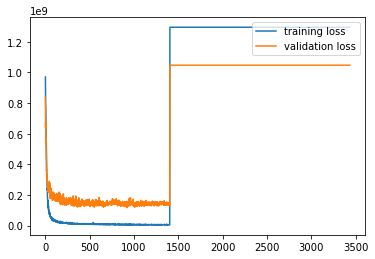

In [12]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [16]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_ep[:3000])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
val_loss_ep[920]

144776103.77520588

In [6]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],s=5,c=exprs,cmap='Greys',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [7]:
def plotExprsDiff(exprsPos,exprsNeg,exprs2,savename,embeddingPos,embeddingNeg,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprsPos is None:
        plt.scatter(embeddingPos[:,0],embeddingPos[:,1],s=5,c=exprsPos,cmap='Reds',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
        plt.scatter(embeddingNeg[:,0],embeddingNeg[:,1],s=5,c=exprsNeg,cmap=plt.cm.get_cmap('Blues'),edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=1200)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [6]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
savenameAdd='_thresh30'
# savenameAdd='_thresh4445'
lossThreshSize=30
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    loss_test_all_binary=np.zeros(inputNp.shape[0])
    loss_test_all_diff=np.zeros(inputNp.shape[0])
    pred_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred.flatten(),labels).item()
        pred_test_all[i]=pred.flatten()[0]
#         if pred[0]*labels[0]>0: 
        if labels[0]>0 and pred[0]>lossThreshSize:
            loss_test_all_binary[i]=0
#         elif pred[0]+labels[0]>0.001: #original
        elif pred[0]>lossThreshSize or labels[0]>0:
            loss_test_all_binary[i]=1
        else:
            loss_test_all_binary[i]=0
        loss_test_all_diff[i]=pred.flatten()[0]-labels[0]
        
    posidx=(labelsNp>0)
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    fig, ax = plt.subplots(dpi=400)
    fig.set_figheight(4)
    fig.set_figwidth(4)
    plt.xscale('log')
    plt.yscale('log')
#     print(labelsNp[posidx])
#     print(pred_test_all[posidx])
    plt.scatter(labelsNp[posidx],pred_test_all[posidx]+0.1)
    plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffscatter_positive'+'.jpg'))
    plt.close()
#     largeridx=np.logical_and(posidx,loss_test_all_diff>=0)
#     smalleridx=np.logical_and(posidx,loss_test_all_diff<0)
#     if np.sum(largeridx)>0:
#         fig, ax = plt.subplots(dpi=400)
#         fig.set_figheight(2.5)
#         fig.set_figwidth(10)
#         plt.xscale('log')
#         plt.hist(loss_test_all_diff[largeridx],bins=np.logspace(np.log10(np.min(loss_test_all_diff[largeridx])),np.log10(np.max(loss_test_all_diff[largeridx])),51))
#         #plt.yscale('log')
#         plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveLarger'+'.jpg'))
#         plt.close()
#     if np.sum(smalleridx)>0:
#         fig, ax = plt.subplots(dpi=400)
#         fig.set_figheight(2.5)
#         fig.set_figwidth(10)
#         plt.xscale('log')
#         plt.hist(np.abs(loss_test_all_diff[smalleridx]),bins=np.logspace(np.log10(np.min(np.abs(loss_test_all_diff[smalleridx]))),np.log10(np.max(np.abs(loss_test_all_diff[smalleridx]))),51))
#         plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveSmaller'+'.jpg'))
#         plt.close()
#     fig, ax = plt.subplots(dpi=400)
#     fig.set_figheight(2.5)
#     fig.set_figwidth(10)
#     plt.xscale('log')
#     plt.hist(loss_test_all_diff[negidx]+0.1,bins=np.logspace(np.log10(np.min(loss_test_all_diff[negidx]+0.1)),np.log10(np.max(loss_test_all_diff[negidx]+0.1)),51))
#     plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_negative'+'.jpg'))
#     plt.close()
    
#     plotExprs(loss_test_all[posidx],loss_test_all[negidx]+0.1,name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     plotExprs(None,loss_test_all[negidx]+0.1,name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     if np.sum(posidx)>0:
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),None,name+'loss'+s+'_diff_positive',coordNp[largeridx],coordNp[smalleridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff2',coordNp[smalleridx],coordNp[largeridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],None,name+'loss'+s+'_diff2_positive',coordNp[smalleridx],coordNp[largeridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     plotExprsDiff(None,None,loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff_negative',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)
#     loss_test_negLoss_binary=np.sum(loss_test_all_binary[negidx])/np.sum(negidx)
#     print(name+' results',
#           'loss positive binary: {:.4f}'.format(loss_test_posLoss_binary),
#          'loss negative binary: {:.4f}'.format(loss_test_negLoss_binary))
    
#     plotExprs(loss_test_all_binary[posidx],loss_test_all_binary[negidx],name+'loss'+s+'_binary',coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all_binary[posidx],None,name+'loss'+s+'_positive'+'_binary',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
#     plotExprs(None,loss_test_all_binary[negidx],name+'loss'+s+'_negative'+'_binary',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)

    
testepoch=920
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch920'
plotepoch+=savenameAdd
for s in sampleidx.keys():
#     if s in ['disease13','disease8']:
#         continue
    print(s)
    if s in ['disease13','disease8']:
        imageslist_s=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    if s in ['control13','control8']:
        imageslist_s=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist_s
    plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
    plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
    plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    plotLoss(np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0),np.concatenate((trainLabelsnp,valLabelsnp,testLabelsnp)),np.concatenate((trainCoordnp,valCoordnp,testCoordnp),axis=0),'all',plotepoch)
    
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=None,None,None,None,None,None,None,None,None
    imageslist_s=None

disease13
plaque1959
no plaque2434
test results loss positive: 170786570.6266 loss negative: 5260318.0735
train results loss positive: 11014505.6488 loss negative: 2642.6826
val results loss positive: 142278050.0234 loss negative: 18022248.6942
all results loss positive: 33167514.2057 loss negative: 1433761.0999
control13
(22355, 18953)
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


<ipython-input-6-21ee77c67f95>:31: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)


test results loss positive: nan loss negative: 828429.0829
train results loss positive: nan loss negative: 1635.9023
val results loss positive: nan loss negative: 227743.7625
all results loss positive: nan loss negative: 95698.3509
disease8
plaque758
no plaque3283
test results loss positive: 421474951.6406 loss negative: 288280924.2286
train results loss positive: 348116902.6674 loss negative: 310862254.4702
val results loss positive: 419683065.6751 loss negative: 335000719.2977
all results loss positive: 359178276.0136 loss negative: 309855004.5609
control8
(22452, 19616)
test results loss positive: nan loss negative: 308222619.4050
train results loss positive: nan loss negative: 295178408.8010
val results loss positive: nan loss negative: 259041457.6069
all results loss positive: nan loss negative: 294680312.5772


In [15]:
labels=testLabelsnp[i]

In [16]:
labels

1

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str